In [648]:
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt


#Call one of the six files
df = pd.read_csv('data/NBA_PBP_2018-19.csv')
df.iloc[:,8:14]

,AwayTeam,AwayPlay,AwayScore,HomeTeam,HomePlay,HomeScore
0,PHI,Jump ball: J. Embiid vs. A. Horford (B. Simmon...,0,BOS,NaN,0
1,PHI,R. Covington misses 3-pt jump shot from 27 ft,0,BOS,NaN,0
2,PHI,NaN,0,BOS,Defensive rebound by Team,0
3,PHI,NaN,0,BOS,J. Tatum misses 3-pt jump shot from 25 ft,0
4,PHI,Defensive rebound by D. ari,0,BOS,NaN,0
...,...,...,...,...,...,...
614511,GSW,S. Livingston enters the game for D. Cousins,106,TOR,NaN,105
614512,GSW,NaN,106,TOR,K. Lowry misses 3-pt jump shot from 22 ft (blo...,105
614513,GSW,Defensive rebound by Team,106,TOR,NaN,105
614514,GSW,End of 4th quarter,106,TOR,NaN,105


In [649]:
def successful_offense(df,team='HOME'):

    #1. Understand if you want HOME or AWAY Team
    if team=='HOME':
        select_team = 0
    else:
        select_team = 1

        
    ### 2. Each Game has HOME and AWAY Teams. We're going to combine
    ### 2.1 Create a df_home. We're Dropping the AWAY information, and renaming columns
    df_home = df.loc[(df['AwayPlay'].isna())]
    df_home = df_home.drop(['AwayTeam', 'AwayPlay','AwayScore'],axis=1)
    df_home.rename(columns={'HomeTeam':'Team',
                            'HomePlay':'Play',
                            'HomeScore':'Score'}, inplace=True)


    ### 2.2 Create a df_away. We're Dropping the AWAY information, and renaming columns
    df_away = df.loc[(df['HomePlay'].isna())]
    df_away = df_away.drop(['HomeTeam', 'HomePlay','HomeScore'],axis=1)
    df_away.rename(columns={'AwayTeam':'Team',
                            'AwayPlay':'Play',
                            'AwayScore':'Score'}, inplace=True)

    ### 2.3 Concatenate and new fields
    df = pd.concat([df_home, df_away])

    ### 3. Selecting only the relevant information

    ### 3.1 Selecting data of that has MAKES or MISS in the Play Column.
    searchfor = [' makes ', ' misses ']
    s = df['Play'].str.contains('|'.join(searchfor))
    df = df.loc[s]

    ### 3.2 Selecting only the fields we will be using
    df = df[['Team','Play','Shooter','ShotType','ShotOutcome','ShotDist','Assister']].reset_index(drop=True)
    
    
    ### 4. We need to enhance and fill the null data.

    ### 4.1 Create Shooter and Assister [Name and ID] Columns
    x = df.Shooter.str.split()
    df['ShooterName'] = x.str[:2].str.join(' ')
    df['ShooterID'] = x.str[3:].str.join(' ')

    y = df.Assister.str.split()
    df['AssisterName'] = y.str[:2].str.join(' ')
    df['AssisterID'] = y.str[3:].str.join(' ')

    ### 4.2 Enhance Freethrow Data

    ### 4.2.1 Create The ShotType 'Free Throw'
    freethrow = df.iloc[:,1].str.contains('free throw')
    df.loc[freethrow, 'ShotType'] = 'free throw'

    ### 4.2.2 Create The Shooter Name from 'Free Throw'
    s = df.iloc[:,1].str.split()
    freethrowName = s.str[:2].str.join(' ')
    df['freethrowName'] = freethrowName
    df['ShooterName'] = df['ShooterName'].fillna(df.pop('freethrowName'))


    ###  4.2.3 Create Free Throw make or miss
    makes_ = df['Play'].str.contains(' makes ')
    misses_ = df['Play'].str.contains(' misses ')
    df.loc[makes_, 'ShotOutcome'] = 'make'
    df.loc[misses_, 'ShotOutcome'] = 'miss'

    ### 4.2.4 Distance of a freethrow (15 feet) https://official.nba.com/rule-no-1-court-dimensions-equipment/
    df['ShotDist'] = df['ShotDist'].fillna(15)

    ### 5. Create ShotValue
    df['ShotValue'] = 0
    df.loc[(df['ShotOutcome']=='make')&(df['ShotType'].str.contains('free throw')), 'ShotValue'] = 1
    df.loc[(df['ShotOutcome']=='make')&(df['ShotType'].str.contains('2-pt')), 'ShotValue'] = 2
    df.loc[(df['ShotOutcome']=='make')&(df['ShotType'].str.contains('3-pt')), 'ShotValue'] = 3

    ### 6. All AssisterName that are null, we will substituting it for ShooterName
    df.AssisterName.fillna(df.ShooterName, inplace=True)

    ### 7. Prepare the Dataset that we need moving forward
    df = df.loc[(df['ShotOutcome']=='make')][['Team','ShooterName','ShotValue','ShotDist','ShotType','AssisterName','ShotOutcome']]

    ### 8. We're selecting only ONE Team
    team_selected = str(list(df['Team'].unique())[select_team])
    df = df.loc[(df['Team']==team_selected)].reset_index(drop=True)
    
    return df
    

In [650]:
### example 1
game_url = list(df['URL'].sample(n=1))[0]
df2 = df.loc[(df['URL']==game_url)]
df2 = successful_offense(df2)
df2.head(5)


,Team,ShooterName,ShotValue,ShotDist,ShotType,AssisterName,ShotOutcome
0,MIA,J. Winslow,1,15.0,free throw,J. Winslow,make
1,MIA,J. Richardson,1,15.0,free throw,J. Richardson,make
2,MIA,J. Richardson,1,15.0,free throw,J. Richardson,make
3,MIA,H. Whiteside,2,1.0,2-pt dunk,R. McGruder,make
4,MIA,R. McGruder,3,23.0,3-pt jump shot,J. Winslow,make


In [651]:
def create_offense(df2):
    ### We need to create an edgelist summarizing all the possible connections between shooters and assiters
    ### 1. Let's take only the 3 values for the graph:
    offense_summary = df2[['ShooterName','AssisterName','ShotValue']]

    ### 2. Create a dataframe with unique edges
    offense_summary = offense_summary.groupby(['ShooterName','AssisterName'])['ShotValue'].sum()

    ### 3. Let's Sort this and 
    offense_summary = pd.DataFrame(offense_summary).reset_index().sort_values(by='ShotValue', ascending=False).reset_index(drop=True)
    
    return offense_summary


def create_graph(offense_summary):
    
    ### Create the graph using NetworkX
    G = nx.from_pandas_edgelist(offense_summary,
                            source='AssisterName', 
                            target='ShooterName',
                            edge_attr=['ShotValue'],
                            create_using=nx.DiGraph())

    return G



def create_individual_offense(offense_summary):
    ### Create a summarized edgelist of Individual Offense
    individual_offense = (offense_summary[['ShooterName','ShotValue']]
                    .loc[(offense_summary['ShooterName']==offense_summary['AssisterName'])]
                    .reset_index(drop=True))
    
    return individual_offense



def create_assisted_offense(offense_summary):
    ### Create a summarized edgelist of Individual Offense
    assisted_offense = (offense_summary[['ShooterName','ShotValue']]
                    .loc[(offense_summary['ShooterName']!=offense_summary['AssisterName'])]
                    .reset_index(drop=True))
    
    return assisted_offense




In [652]:
def draw_networkgraph(df2, ax):

    offense_summary = create_offense(df2)
    individual_offense = create_individual_offense(offense_summary)    
    G = create_graph(offense_summary)
    
    ###### DRAWING NODES #######
    '''
    The size of the nodes will be proportional to 
    the amount of scoring they create by themselves
    without the help of an assist
    '''

    individual_offense = (offense_summary[['ShooterName','ShotValue']]
                        .loc[(offense_summary['ShooterName']==offense_summary['AssisterName'])]
                        .reset_index(drop=True))

    a = dict(zip(individual_offense['ShooterName'],individual_offense['ShotValue']))
    for k, v in a.items():
        a[k] = float(v)

    players_solo_score = dict.fromkeys(G.nodes(), 0)
    players_solo_score.update(a)

    for k, v in players_solo_score.items():
        players_solo_score[k] = float(v)

    nodesize = np.array(list(players_solo_score.values()))
    nodesize = nodesize/np.sum(nodesize)
    nodesize = [i*10000 for i in nodesize]

    ###### DRAWING EDGES #######
    '''
    The width of the edges will be proportional to the amount
    of points created by an assist between two players.
    '''
    #EdgeList
    non_assisted = [(u, v) for (u, v, d) in G.edges(data=True) if u != v]

    #EdgeSize
    edgesize = [(d) for (u, v, d) in G.edges(data=True) if u != v]
    edgesize = np.array([value['ShotValue'] for value in edgesize])
    edgesize = edgesize/np.sum(edgesize)*100


    ###### DRAWING GRAPH #######

    # Position of the Nodes in the Graph (Circular)
    pos = nx.circular_layout(G)
    

    # Drawing Nodes
    nx.draw_networkx_nodes(G, pos, 
                        node_size=nodesize, 
                        node_color='green',
                        alpha=0.5)


    # Drawing Edges
    nx.draw_networkx_edges(G, pos, 
                        edgelist=non_assisted, 
                        width=edgesize, 
                        alpha=0.2, 
                        arrows=True,
                        arrowstyle='-',
                        arrowsize=20,
                        edge_color="black")

    # Dreawing Labels
    label_options = {"ec": "k", "fc": "green", "alpha": 0.01}
    nx.draw_networkx_labels(G, pos, 
                            font_size=7, font_family="sans-serif", font_color='black',
                            verticalalignment='bottom',
                            horizontalalignment = 'center',
                            bbox=label_options
                            )

    ax.set_title(
        "Network of Points between players",
        loc='center',
        fontsize=12,
        weight='bold',
        color='gray',
        wrap=True
            )

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    # return ax    

In [653]:
def draw_adjancecy_matrix(df2, fig, ax):

    offense_summary = create_offense(df2)
    # individual_offense = create_individual_offense(offense_summary)    
    G = create_graph(offense_summary)
    
    A = nx.adjacency_matrix(G,weight='ShotValue',)
    matrix = A.todense()
    assiters = list(G.nodes())
    scorers = list(G.nodes())

    # fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap='Greens')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(assiters)), labels=assiters)
    ax.set_yticks(np.arange(len(scorers)), labels=scorers)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(scorers)):
        for j in range(len(assiters)):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="black")

    ax.set_title(
           "Points Distributed by Scorer and Assister",
            loc='center',
            fontsize=12,
            weight='bold',
            color='gray',
            wrap=True
                )

    fig.tight_layout()
    # return plt.show()

In [654]:
def create_offense_summary(df):
    extract_columns = ['Type of Play',
                       'Total Points',
                       '3 Points',
                       '2 Points',
                       'Free Throw',
                       'Avg. Shot Distance (feet)']

    offense_extract = pd.DataFrame(columns=extract_columns)
    
    a = df2[['ShooterName','AssisterName','ShotValue','ShotDist']]
    x = a

    total_points = x['ShotValue'].sum()
    total_points_3p = x.loc[(x['ShotValue']==3)]['ShotValue'].sum()
    total_points_2p = x.loc[(x['ShotValue']==2)]['ShotValue'].sum()
    total_points_1p = x.loc[(x['ShotValue']==1)]['ShotValue'].sum()
    total_points_dist = round(x.loc[(x['ShotValue']!=1)]['ShotDist'].mean(),2)
    offensive_vector = ['Total',total_points, total_points_3p, total_points_2p , total_points_1p, total_points_dist]
    offense_extract.loc[len(offense_extract)] = offensive_vector

    x = a.loc[(a['ShooterName'] ==a['AssisterName'])]
    assisted_points = x['ShotValue'].sum()
    assisted_points_3p = x.loc[(x['ShotValue']==3)]['ShotValue'].sum()
    assisted_points_2p = x.loc[(x['ShotValue']==2)]['ShotValue'].sum()
    assisted_points_1p = x.loc[(x['ShotValue']==1)]['ShotValue'].sum()
    assisted_points_dist = round(x.loc[(x['ShotValue']!=1)]['ShotDist'].mean(),2)
    offensive_vector = ['Assisted',assisted_points, assisted_points_3p, assisted_points_2p , assisted_points_1p, assisted_points_dist]
    offense_extract.loc[len(offense_extract)] = offensive_vector

    x = a.loc[(a['ShooterName'] !=a['AssisterName'])]
    solo_points = x['ShotValue'].sum()
    solo_points_3p = x.loc[(x['ShotValue']==3)]['ShotValue'].sum()
    solo_points_2p = x.loc[(x['ShotValue']==2)]['ShotValue'].sum()
    solo_points_1p = x.loc[(x['ShotValue']==1)]['ShotValue'].sum()
    solo_points_dist = round(x.loc[(x['ShotValue']!=1)]['ShotDist'].mean(),2)
    offensive_vector = ['Solo',solo_points, solo_points_3p, solo_points_2p , solo_points_1p, solo_points_dist]
    offense_extract.loc[len(offense_extract)] = offensive_vector
      
    return offense_extract

In [655]:
def draw_game_summary(df, ax):
        # making the structure
        # fig, ax = plt.subplots(figsize=(10,4))

        rows = 3 # number of rows that we want
        cols = 6 # number of columns that we want


        ax.set_ylim(-0.5, rows) #  y limits
        ax.set_xlim(0, cols) #  X limits
        ax.axis('off') # removing all the spines
        
        offense_extract = create_offense_summary(df)
        matrix = offense_extract

        # iterating over each row of the dataframe and plot the text
        # df_working is a DataFrame object with our fake data
        for row in matrix.iloc[:,:].iterrows(): # this will return the row as a tupple
                
                # row[0] will be the index of the row
                # row[1] will be the actual data as a Series
                x_position = 0.5
                for i in matrix.columns:
                        ax.text(x=x_position,  
                                y=row[0], 
                                s=row[1][i], 
                                va="center", 
                                ha="center", 
                                size=10)
                        ax.text(x_position, 
                                rows-0.5, str(i), 
                                weight='bold', 
                                ha='center', 
                                size=10,
                                color='green',
                                alpha=0.5,
                                wrap=True)._get_wrap_line_width = lambda : 100
                        x_position+=1


        # Adding title
        ax.set_title(
                'Points Splitted by Assisted and Solo Play',
                loc='center',
                fontsize=12,
                weight='bold',
                color='gray',
                wrap=True
        )

        # adds main line belowthe headers
        # ax.plot([.25,cols-.2], [rows-1.5, rows-1.5],ls="-",lw=1,c="black")

        # adds multiple lines below each row
        for row in matrix.iterrows():
                ax.plot(
                [.25, cols-.2],
                [row[0] -.5, row[0] - .5],
                ls=':',
                lw='.5',
                c='grey'
                )
        # return ax

In [656]:
def draw_dashboard(df2):
    fig = plt.figure("Degree of a random graph", figsize=(12, 8))

    axgrid = fig.add_gridspec(10, 6)

    ax0 = fig.add_subplot(axgrid[1:4, :])
    draw_game_summary(df2, ax0)

    ax1 = fig.add_subplot(axgrid[4:, :4])
    draw_networkgraph(df2, ax1)

    ax2 = fig.add_subplot(axgrid[4:, 4:])
    draw_adjancecy_matrix(df2, fig, ax2)

    # Add lines between subplots
    fig.add_artist(plt.Line2D((0.00, 1), (0.65, 0.65), color='gray', linewidth=0.5, linestyle=':'))
    fig.add_artist(plt.Line2D((0.6, 0.6), (0.65, 0), color='gray', linewidth=0.5, linestyle=':'))
    # fig.add_artist(plt.Line2D((0.05, 0.95), (0.82, 0.82), color='black', linewidth=1))
    fig.suptitle(str('Analysis of a Basketball Game - Network Perspective '), fontsize=16,  weight='bold',color='black')

    plt.show()


/var/folders/mv/mkg__7515n9dswqmhcq_vz980000gn/T/ipykernel_50780/1782597910.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G,weight='ShotValue',)


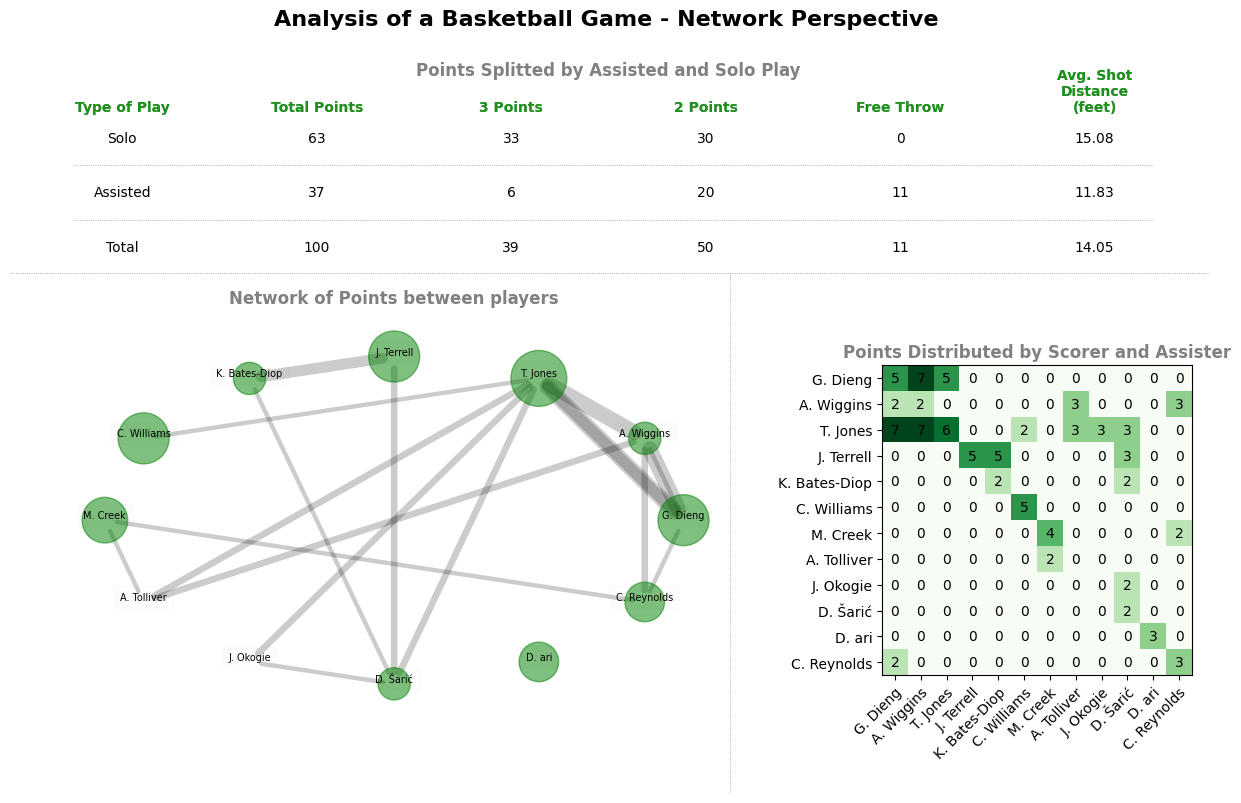

In [771]:
game_url = list(df['URL'].sample(n=1))[0]
df2 = df.loc[(df['URL']==game_url)]
df2 = successful_offense(df2)
draw_dashboard(df2)